In [1]:
import numpy as np
import numba
import sklearn.datasets
import umap
import pynndescent
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.sparse
import sklearn.metrics

from collections import namedtuple

sns.set(rc={"figure.figsize":(12, 12)})

## Build the Graph

The goal is to contruct a graph with edge weights given by estimating the probability of being the nearest neighbor. How can we estimate such a probability? Surely the sample is either the nearest neighbor or it isn't? We assume sampling has been random and somewhat noisy; but that the distribution of samples is *locally* uniform. In other words we assume that in a local region there is a distribution of distances to the nearest neighbor. This distribution is asymptotically a Gamma distribution; since we are in high dimensions this can be well approximated by a normal distribution (which is much cheaper to model, and to compute probabilities for). Thus for each sample we consider it's local neighborhood and fit a model of the distance to the nearest neighbor for samples in that neighborhood. Given such a model we can then compute the probability that the nearest neighbor of the sample is at least as far away as any given sample, and thus create an edge with w weight given by the probability that this point would have been the nearest neighbor under our model. This provides a (directed!) graph with proabiulities assigned to edges.

In [2]:
# Construct the models (using V(X) = E(X^2) - E(X)^2 so we can stream through the data)
# Quirk: We use the 2-out neighborhood and accept the double counting of neighbors of neightbors
#        that overlap. The 2-out lets us see further; the double counting biases toward 
#        the coherent local region as opposed to outliers. Also it just works better. Better
#        options or justifications are more than welcome.
@numba.njit(fastmath=True)
def build_models(nn_inds, nn_dists):
    result = np.zeros((nn_inds.shape[0], 2), dtype=np.float32)
    sums = np.zeros(nn_inds.shape[0], dtype=np.float32)
    sums_of_squares = np.zeros(nn_inds.shape[0], dtype=np.float32)
    counts = np.zeros(nn_inds.shape[0], dtype=np.float32)
    # Get sums and counts for the 1-out (not including the points own 1-nn dist)
    for i in range(nn_inds.shape[0]):
        for j in range(1, nn_inds.shape[1]):
            k = nn_inds[i, j]
            if k != i and nn_dists[k] > 0.0: # Skip zero dists since they don't fit the model
                d = nn_dists[k]
                sums[i] += d
                sums_of_squares[i] += d * d
                counts[i] += 1.0
                
    # Total up totals for the 2-out then compute the mean and std
    for i in range(nn_inds.shape[0]):
        count = 0
        for j in range(nn_inds.shape[1]):
            k = nn_inds[i, j]
            result[i, 0] += sums[k]
            result[i, 1] += sums_of_squares[k]
            count += counts[k]
            
        result[i, 0] /= count
        result[i, 1] = np.sqrt(result[i, 1] / count - result[i, 0] ** 2)
        
    return result
    
# Create an edge list of the (directed!) prob of being a nearest neighbor
# This amounts to just computing the relevant prob of the relevant normal using erfc from
# the math library.
@numba.njit(fastmath=True)
def build_edges(nn_inds, nn_dists, models, max_total_weight=32.0, min_prob=1e-3):
    result = []
    root_two = np.sqrt(2)
    for i in range(nn_inds.shape[0]):
        mean = models[i, 0]
        std = models[i, 1]
        total_weight = 0.0
        
        for j in range(nn_inds.shape[1]):
            k = nn_inds[i, j]
            if nn_dists[i, j] == 0:
                if i != k:
                    result.append((i, k, 1.0))
                else:
                    continue
                    
            d = nn_dists[i, j]
            if std > 0:
                erfc_input = (d - mean) / (root_two * std)
                val = math.erfc(erfc_input) / 2.0
            else:
                val = 0.0
            

            total_weight += val
            if total_weight > max_total_weight or val < min_prob:
                break
            else:
                result.append((i, k, val))
            
    return result

# Build the graph: compute nearest neighbors (approximately), build models from them, then make an edge
# list and convert that into a scipy sparse matrix.
def construct_prob_graph(data, n_neighbors=30, metric="euclidean", max_total_weight=32.0, min_prob=1e-3, k=1):
    nn_index = pynndescent.NNDescent(data, metric=metric, n_neighbors=2 * n_neighbors)
    nn_inds, nn_dists = nn_index.neighbor_graph
    models = build_models(nn_inds, nn_dists[:, k])
    
    graph_edges = np.asarray(
        build_edges(nn_inds, nn_dists, models, max_total_weight=max_total_weight, min_prob=min_prob)
    )
    result = scipy.sparse.coo_matrix(
        (graph_edges.T[2], (graph_edges.T[0].astype(np.int32), graph_edges.T[1].astype(np.int32))),
        shape=(data.shape[0], data.shape[0])
    )
    result.eliminate_zeros()
    
    return result

## Cluster the graph

We can run single linkage clustering on the resulting graph, and then use HDBSCAN style condensed tree approaches to simplify and get some clusters out. Unfortunately we have a directed graph that may not have a single connected component; that means we need to be able to construct minimal spanning forests, convert them to a set of merge trees, and then run HDBSCAN style tree condensing on the forests of merge trees. None of this is hard, but it is finicky, and we want it all to run fast. Before we get started then we need to build some tools -- specifically a disjoint-set/union-find system which will be used repeatedly in what follows.

In [4]:
RankDisjointSet = namedtuple("DisjointSet", ["parent", "rank"])
SizeDisjointSet = namedtuple("DisjointSet", ["parent", "size"])


@numba.njit()
def ds_rank_create(n_elements):
    return RankDisjointSet(np.arange(n_elements, dtype=np.int32), np.zeros(n_elements, dtype=np.int32))


@numba.njit()
def ds_size_create(n_elements):
    return SizeDisjointSet(np.arange(n_elements, dtype=np.int32), np.ones(n_elements, dtype=np.int32))


@numba.njit()
def ds_find(disjoint_set, x):
    while disjoint_set.parent[x] != x:
        x, disjoint_set.parent[x] = disjoint_set.parent[x], disjoint_set.parent[disjoint_set.parent[x]]

    return x


@numba.njit()
def ds_union_by_rank(disjoint_set, x, y):
    x = ds_find(disjoint_set, x)
    y = ds_find(disjoint_set, y)

    if x == y:
        return

    if disjoint_set.rank[x] < disjoint_set.rank[y]:
        x, y = y, x

    disjoint_set.parent[y] = x
    if disjoint_set.rank[x] == disjoint_set.rank[y]:
        disjoint_set.rank[x] += 1


@numba.njit()
def ds_union_by_size(disjoint_set, x, y):
    x = ds_find(disjoint_set, x)
    y = ds_find(disjoint_set, y)

    if x == y:
        return

    if disjoint_set.size[x] < disjoint_set.size[y]:
        x, y = y, x

    disjoint_set.parent[y] = x
    disjoint_set.size[x] += disjoint_set.size[y]

Next we need single linkage clustering of the graph. That is most easily done by computing a minimum spanning forest, and then processing that into a forest of merge trees. We could use scipy here, but we want flexibility (for forests instead of trees), and they just use Kruskal's algorithm anyway, which is easy to reproduce here. After that we just need the standard process for converting a spanning tree (or forest) to a merge tree (or forest). In practice I think this can all be simplified to one function, since we are doing the merge work in Kruskal's but for now let's keep things as separate standard algorithms.

Note that to use minimum spanning forests, and merge order structures we need things going in the other order than probabilities, so we just use negative logs (after all, it's only order that matters).

In [5]:
@numba.njit()
def kruskal_minimum_spanning_forest(rows, cols, data, n_vertices):
    
    result_row = np.zeros(n_vertices - 1, dtype=np.int64)
    result_col = np.zeros(n_vertices - 1, dtype=np.int64)
    result_data = np.zeros(n_vertices - 1, dtype=np.float32)
    mst_edge_idx = 0
        
    edge_order = np.argsort(data)
    disjoint_set = ds_rank_create(n_vertices)
    
    for n in range(data.shape[0]):
        edge_idx = edge_order[n]
        i = rows[edge_idx]
        j = cols[edge_idx]
        
        i_component = ds_find(disjoint_set, i)
        j_component = ds_find(disjoint_set, j)
        
        if i_component != j_component:
            result_row[mst_edge_idx] = i
            result_col[mst_edge_idx] = j
            result_data[mst_edge_idx] = data[edge_idx]
            mst_edge_idx += 1
            ds_union_by_rank(disjoint_set, i, j)
            
            if mst_edge_idx >= n_vertices - 1:
                break
            
    return result_row[:mst_edge_idx], result_col[:mst_edge_idx], result_data[:mst_edge_idx]

LinkageMergeData = namedtuple("LinkageMergeData", ["parent", "size", "next"])


@numba.njit()
def create_linkage_merge_data(base_size):
    parent = np.full(2 * base_size - 1, -1, dtype=np.intp)
    size = np.concatenate((np.ones(base_size, dtype=np.intp), np.zeros(base_size - 1, dtype=np.intp)))
    next_parent = np.array([base_size], dtype=np.intp)

    return LinkageMergeData(parent, size, next_parent)


@numba.njit()
def linkage_merge_find(linkage_merge, node):
    relabel = node
    while linkage_merge.parent[node] != -1 and linkage_merge.parent[node] != node:
        node = linkage_merge.parent[node]

    linkage_merge.parent[node] = node

    # label up to the root
    while linkage_merge.parent[relabel] != node:
        next_relabel = linkage_merge.parent[relabel]
        linkage_merge.parent[relabel] = node
        relabel = next_relabel

    return node


@numba.njit()
def linkage_merge_join(linkage_merge, left, right):
    linkage_merge.size[linkage_merge.next[0]] = linkage_merge.size[left] + linkage_merge.size[right]
    linkage_merge.parent[left] = linkage_merge.next[0]
    linkage_merge.parent[right] = linkage_merge.next[0]
    linkage_merge.next[0] += 1


@numba.njit()
def msf_to_linkage_forest(sorted_mst, n_samples=-1):
    result = np.empty((sorted_mst.shape[0], sorted_mst.shape[1] + 1))

    if n_samples < 0:
        n_samples = sorted_mst.shape[0] + 1
        
    linkage_merge = create_linkage_merge_data(n_samples)

    for index in range(sorted_mst.shape[0]):

        left = np.intp(sorted_mst[index, 0])
        right = np.intp(sorted_mst[index, 1])
        delta = sorted_mst[index, 2]

        left_component = linkage_merge_find(linkage_merge, left)
        right_component = linkage_merge_find(linkage_merge, right)

        if left_component > right_component:
            result[index][0] = left_component
            result[index][1] = right_component
        else:
            result[index][1] = left_component
            result[index][0] = right_component

        result[index][2] = delta
        result[index][3] = linkage_merge.size[left_component] + linkage_merge.size[right_component]

        linkage_merge_join(linkage_merge, left_component, right_component)

    return result

def merge_forest_from_graph(prob_graph):
    
    if scipy.sparse.isspmatrix_coo(prob_graph):
        graph_for_linkage = prob_graph
    else:
        graph_for_linkage = prob_graph.tocoo()
        
    msf = kruskal_minimum_spanning_forest(
        graph_for_linkage.row, graph_for_linkage.col, -np.log(graph_for_linkage.data), graph_for_linkage.shape[0]
    )
    msf = np.vstack(msf).T
    merge_forest = msf_to_linkage_forest(msf, graph_for_linkage.shape[0])
    
    return merge_forest

Next we need to be able to condense trees, and also forests. We can just use the standard ``condense_tree`` code (see fast_hdbscan) with some minor modifications where the number of points isn't automatically/implicitly encoded in the merge tree structure. We then supplement that with the ability to extract out roots of the merge forest, and then simply run ``condense_tree`` for each tree in our merge forest, and glue the whole thing together when done.

In [6]:
@numba.njit()
def bfs_from_hierarchy(hierarchy, bfs_root, num_points):
    to_process = [bfs_root]
    result = []

    while to_process:
        result.extend(to_process)
        next_to_process = []
        for n in to_process:
            if n >= num_points:
                i = n - num_points
                next_to_process.append(int(hierarchy[i, 0]))
                next_to_process.append(int(hierarchy[i, 1]))
        to_process = next_to_process

    return result

@numba.njit()
def eliminate_branch(branch_node, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore, hierarchy,
                     num_points):
    if branch_node < num_points:
        parents[idx] = parent_node
        children[idx] = branch_node
        lambdas[idx] = lambda_value
        idx += 1
    else:
        for sub_node in bfs_from_hierarchy(hierarchy, branch_node, num_points):
            if sub_node < num_points:
                children[idx] = sub_node
                parents[idx] = parent_node
                lambdas[idx] = lambda_value
                idx += 1
            else:
                ignore[sub_node] = True

    return idx


CondensedTree = namedtuple('CondensedTree', ['parent', 'child', 'lambda_val', 'child_size'])

@numba.njit()
def neg_exp(x):
    return np.exp(-x)

@numba.njit(fastmath=True)
def condense_tree(hierarchy, min_cluster_size=10, root=-1, num_points=-1, next_label=-1, lambda_func=neg_exp):
    
    if root < 0:
        root = 2 * hierarchy.shape[0]
        
    if num_points < 0:
        num_points = hierarchy.shape[0] + 1
        
    if next_label < 0:
        next_label = num_points

    node_list = bfs_from_hierarchy(hierarchy, root, num_points)

    relabel = np.zeros(root + 1, dtype=np.int64)
    relabel[root] = next_label
    
    next_label += 1

    parents = np.ones(root, dtype=np.int64)
    children = np.empty(root, dtype=np.int64)
    lambdas = np.empty(root, dtype=np.float32)
    sizes = np.ones(root, dtype=np.int64)

    ignore = np.zeros(root + 1, dtype=np.bool8)

    idx = 0

    for node in node_list:
        if ignore[node] or node < num_points:
            continue

        parent_node = relabel[node]
        l, r, d, _ = hierarchy[node - num_points]
        left = np.int64(l)
        right = np.int64(r)
        lambda_value = lambda_func(d)

        left_count = np.int64(hierarchy[left - num_points, 3]) if left >= num_points else 1
        right_count = np.int64(hierarchy[right - num_points, 3]) if right >= num_points else 1

        # The logic here is in a strange order, but it has non-trivial performance gains ...
        # The most common case by far is a singleton on the left; and cluster on the right take care of this separately
        if left < num_points and right_count >= min_cluster_size:
            relabel[right] = parent_node
            parents[idx] = parent_node
            children[idx] = left
            lambdas[idx] = lambda_value
            idx += 1
        # Next most common is a small left cluster and a large right cluster: 
        #   relabel the right node; eliminate the left branch
        elif left_count < min_cluster_size and right_count >= min_cluster_size:
            relabel[right] = parent_node
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # Then we have a large left cluster and a small right cluster: relabel the left node; elimiate the right branch
        elif left_count >= min_cluster_size and right_count < min_cluster_size:
            relabel[left] = parent_node
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # If both clusters are small then eliminate all branches
        elif left_count < min_cluster_size and right_count < min_cluster_size:
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # and finally if we actually have a legitimate cluster split, handle that correctly
        else:
            relabel[left] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = left_count
            next_label += 1
            idx += 1

            relabel[right] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = right_count
            next_label += 1
            idx += 1

    return CondensedTree(parents[:idx], children[:idx], lambdas[:idx], sizes[:idx])

@numba.njit()
def merge_tree_roots(merge_tree, min_cluster_size, n_samples=-1):
    if n_samples < 0:
        n_samples = merge_tree.shape[0] + 1
        
    is_root = np.ones(merge_tree.shape[0], dtype=np.bool_)
    for i in range(merge_tree.shape[0]):
        if merge_tree[i, 0] >= n_samples:
            is_root[int(merge_tree[i, 0] - n_samples)] = False
        if merge_tree[i, 1] >= n_samples:
            is_root[int(merge_tree[i, 1] - n_samples)] = False
        
    roots = np.nonzero(is_root)[0] + n_samples
    
    result = []
    for i in range(roots.shape[0]):
        if merge_tree[roots[i] - n_samples, 3] > min_cluster_size:
            result.append(roots[i])
        
    return result

#@numba.njit()
def condense_forest(merge_forest, min_cluster_size=10, n_samples=-1, lambda_func=neg_exp):

    if n_samples < 0:
        n_samples = merge_tree.shape[0] + 1
        
    roots = merge_tree_roots(merge_forest, min_cluster_size=min_cluster_size, n_samples=n_samples)
    
    ctrees = []
    next_label = n_samples + 1
    for root in roots:
        ctree = condense_tree(
            merge_forest, 
            min_cluster_size=min_cluster_size, 
            root=root, 
            num_points=n_samples,
            next_label=next_label,
            lambda_func=lambda_func,
        )
        next_label = ctree.parent.max() + 1
        ctrees.append(ctree)
        
    result = CondensedTree(
        np.concatenate([x.parent for x in ctrees]),
        np.concatenate([x.child for x in ctrees]),
        np.concatenate([x.lambda_val for x in ctrees]),
        np.concatenate([x.child_size for x in ctrees]),
    )
    return result

Lastly we need to be able to extract clusters. We could use any technique, but I went with the leaf extraction because it seemed to work better. In principle this means we don't need to condense the whole tree, just the leaves which could save a lot of time/trouble, but other extraction methods are possible so I'll stick with flexibility (and borrowed standard algorithms) for now.

In [7]:
@numba.njit
def extract_leaves(condensed_tree, allow_single_cluster=True):
    n_points = condensed_tree.parent.min()
    n_nodes = max(condensed_tree.parent.max() + 1, n_points + 1)
    leaf_indicator = np.ones(n_nodes, dtype=np.bool_)
    leaf_indicator[:n_points] = False

    for parent, child_size in zip(condensed_tree.parent, condensed_tree.child_size):
        if child_size > 1:
            leaf_indicator[parent] = False

    return np.nonzero(leaf_indicator)[0]

@numba.njit()
def get_cluster_label_vector(
        tree,
        clusters,
):
    root_cluster = tree.parent.min()
    result = np.empty(root_cluster, dtype=np.intp)
    cluster_label_map = {c: n for n, c in enumerate(np.sort(clusters))}

    disjoint_set = ds_rank_create(tree.parent.max() + 1)
    clusters = set(clusters)

    for n in range(tree.parent.shape[0]):
        child = tree.child[n]
        parent = tree.parent[n]
        if child not in clusters:
            ds_union_by_rank(disjoint_set, parent, child)

    for n in range(root_cluster):
        cluster = ds_find(disjoint_set, n)
        if cluster in cluster_label_map:
            result[n] = cluster_label_map[cluster]
        else:
            result[n] = -1

    return result


def labels_from_prob_graph(prob_graph, min_cluster_size):
    
    merge_forest = merge_forest_from_graph(prob_graph)
    condensed_forest = condense_forest(merge_forest, min_cluster_size=min_cluster_size, n_samples=prob_graph.shape[0])
    chosen_clusters = extract_leaves(condensed_forest)
    
    result = get_cluster_label_vector(condensed_forest, chosen_clusters)
    
    return result

## Propagate labels through the graph

The clustering of the graph works well in that it picks out most of the clusters, but it leaves a great deal of data as noise. We can fix that by running a label propagation through the graph. We do still want to keep the ability to label points as noise, and it would be good to keep the propagation soft, so we can do a Bayesian label propagation of probability vectors over possible labels, including a noise label, with a Bayesian update of the distribution at each propagation round. We can then iterate until relative convergence.

In [8]:
# A basic Bayesian label prop with a few quirks
# Quirks: Different vertices have different (weighted) degrees; we normalize so the total outgoing weight is consistent
#         We reassert labels each iteration boosting the prior; this includes a level of noise prior which is a parameter
#         This is not really theoretically sound, but it prevents labels over-running where they shouldn't. We could in
#         theory simply hold labelled vertics fixed; I haven't experimented with that much yet.
@numba.njit(fastmath=True, parallel=True)
def bayesian_label_prop_iteration(
    indptr, indices, probs, vertex_label_probs, labels, degree_correction, prior=10.0, noise_prior_prob=0.0
):
    
    n_rows = indptr.shape[0] - 1
    n_labels = vertex_label_probs.shape[1]
    vertex_votes = np.zeros_like(vertex_label_probs, dtype=np.float64)
    norms = np.zeros(n_rows)
    for i in numba.prange(n_rows):
        if labels[i] >= 0:
            vertex_votes[i] = prior * vertex_label_probs[i]
            norms[i] += prior
        else:
            vertex_votes[i] = noise_prior_prob * vertex_label_probs[i]
            norms[i] += noise_prior_prob
#         if labels[i] >= 0:
#             vertex_votes[i, labels[i]] = 1.0
#             norms[i] += 1.0
#         else:
#             vertex_votes[i, -1] += noise_prior_prob
#             norms[i] += noise_prior_prob
        
    for i in numba.prange(n_rows):
        for k in range(indptr[i], indptr[i+1]):
            j = indices[k]
            prob = probs[k] * degree_correction[i]
            
            for l in range(n_labels):
                vertex_votes[i, l] += prob * vertex_label_probs[j, l]
                
            norms[i] += prob
        
    for i in numba.prange(n_rows):
        if norms[i] > 0.0:
            vertex_votes[i] /= norms[i]
        else:
            vertex_votes[i, -1] = 1.0
            
    return vertex_votes


def bayesian_label_prop(prob_graph, label_vector, noise_prior_prob=0.0, max_iter=100, tolerance=1e-5, prior=10.0):
    if not scipy.sparse.isspmatrix_csr(prob_graph):
        prob_graph = prob_graph.tocsr()
        
    vertex_label_probs = np.zeros((prob_graph.shape[0], label_vector.max() + 2), dtype=np.float64)
    for i in range(vertex_label_probs.shape[0]):
        vertex_label_probs[i, label_vector[i]] = 1.0
        
    degree_correction = 1.0 / (np.squeeze(np.array(prob_graph.sum(axis=0))) + 1e-3)
    for i in range(max_iter):
        next_vertex_label_probs = bayesian_label_prop_iteration(
            prob_graph.indptr, 
            prob_graph.indices, 
            prob_graph.data, 
            vertex_label_probs, 
            label_vector,
            degree_correction,
            noise_prior_prob=noise_prior_prob,
            prior=prior,
        )
        
        total_change = np.sqrt(np.sum((vertex_label_probs - next_vertex_label_probs)**2))
        
        if total_change / prob_graph.shape[0] < tolerance:
            return next_vertex_label_probs
        else:
            vertex_label_probs = next_vertex_label_probs
            
    return vertex_label_probs

## Putting it all together

We can now put together a clustering algorithm from these pieces. This follows exactly the sections: create the graph; cluster the graph; propagate the initial cluster labels through the graph.

In [9]:
def clusters(
    data,
    metric="euclidean",
    n_neighbors=30,
    min_cluster_size=10,
    max_total_weight=64.0, 
    min_prob=1e-3,
    prior=10.0,
    noise_prior_prob=0.0, 
    max_iter=100, 
    tolerance=1e-5,
    k=1,
):
    prob_graph = construct_prob_graph(
        data, 
        n_neighbors=n_neighbors, 
        metric=metric, 
        max_total_weight=max_total_weight, 
        min_prob=min_prob,
        k=k,
    )
    label_vector = labels_from_prob_graph(prob_graph, min_cluster_size)
    cluster_prob_vector = bayesian_label_prop(
        prob_graph, label_vector, 
        noise_prior_prob=noise_prior_prob, 
        max_iter=max_iter, 
        tolerance=tolerance,
        prior=prior,
    )
    result = np.argmax(cluster_prob_vector, axis=1)
    result[result == label_vector.max() + 1] = -1
    
    return result

In [25]:
data = mnist.data
metric="euclidean"
n_neighbors=30
min_cluster_size=800
max_total_weight=64.0 
min_prob=1e-3
prior=10.0
noise_prior_prob=0.01 
max_iter=100 
tolerance=1e-5
k=1

In [32]:
prob_graph = construct_prob_graph(
    data, 
    n_neighbors=n_neighbors, 
    metric=metric, 
    max_total_weight=max_total_weight, 
    min_prob=min_prob,
    k=k,
)
label_vector = labels_from_prob_graph(prob_graph, min_cluster_size)
cluster_prob_vector = bayesian_label_prop(
    prob_graph, label_vector, 
    noise_prior_prob=noise_prior_prob, 
    max_iter=max_iter, 
    tolerance=tolerance,
    prior=prior,
)
result = np.argmax(cluster_prob_vector, axis=1)
result[result == label_vector.max() + 1] = -1

In [45]:
in_degrees = prob_graph.sum(axis=0)
# sns.histplot(random.choice(in_degrees, 5000))

## Experiments

We'll run this algorithm (with tuned parameters) and compare it with a combination of UMAP and HDBSCAN (with tuned parameters). This algorithm was developed largely against MNIST, so it is perhaps somewhat overtuned to MNIST. You may want to substitute in your own favourite dataset instead; alhtough it should be "high dimensional" enough the not require Gamma distribution models (above about 10 should probably be enough).

In [10]:
mnist = sklearn.datasets.fetch_openml("mnist_784")

In [11]:
%%time
mnist_umap = umap.UMAP(min_dist=0.25).fit_transform(mnist.data)

CPU times: user 26min 21s, sys: 1min 23s, total: 27min 45s
Wall time: 47.6 s


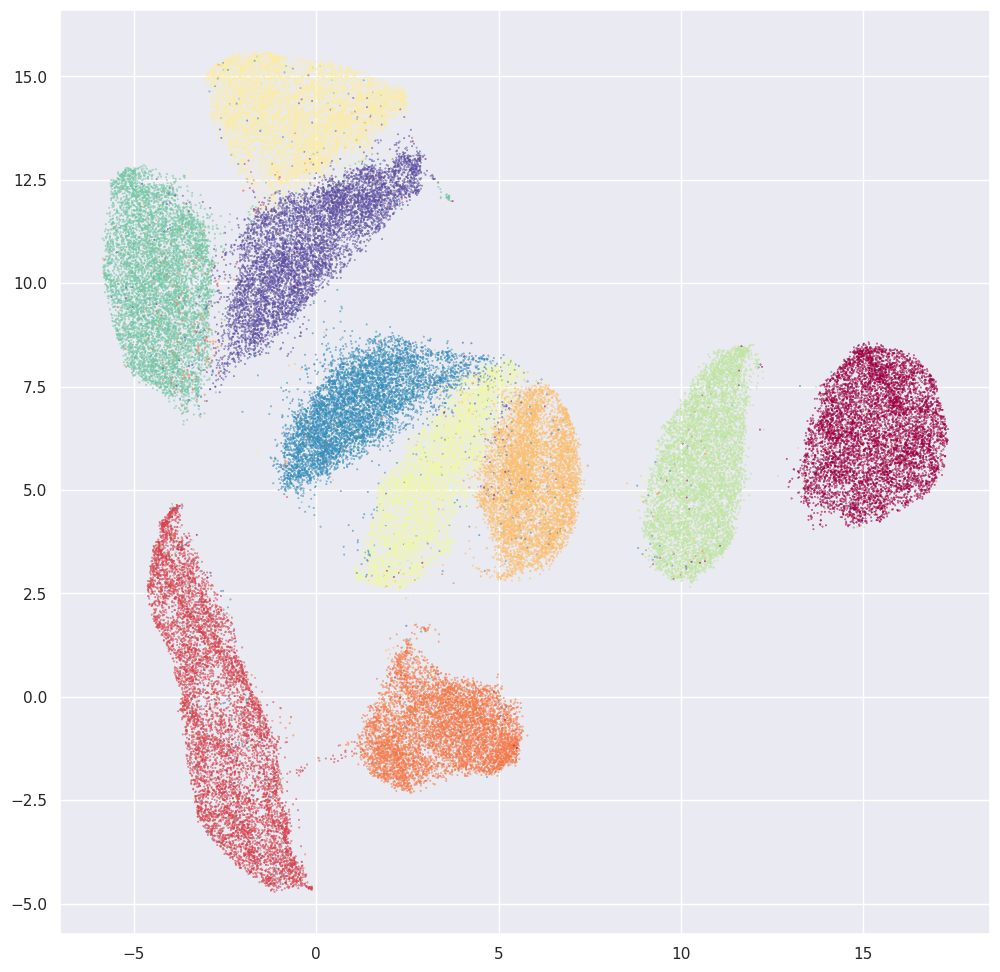

In [12]:
plt.scatter(*mnist_umap.T, s=0.1, c=mnist.target.astype(np.int8), cmap="Spectral")

The first run does the compilation; the second run gives a better sense of time required.

In [13]:
%%time
mnist_clusters = clusters(mnist.data, min_cluster_size=800, n_neighbors=30, noise_prior_prob=0.01)

CPU times: user 3min 43s, sys: 18.8 s, total: 4min 1s
Wall time: 27.2 s


In [14]:
%%time
mnist_clusters = clusters(mnist.data, min_cluster_size=800, n_neighbors=15, prior=100.0, noise_prior_prob=0.0, max_iter=100)

CPU times: user 1min 38s, sys: 1min 30s, total: 3min 8s
Wall time: 9.01 s


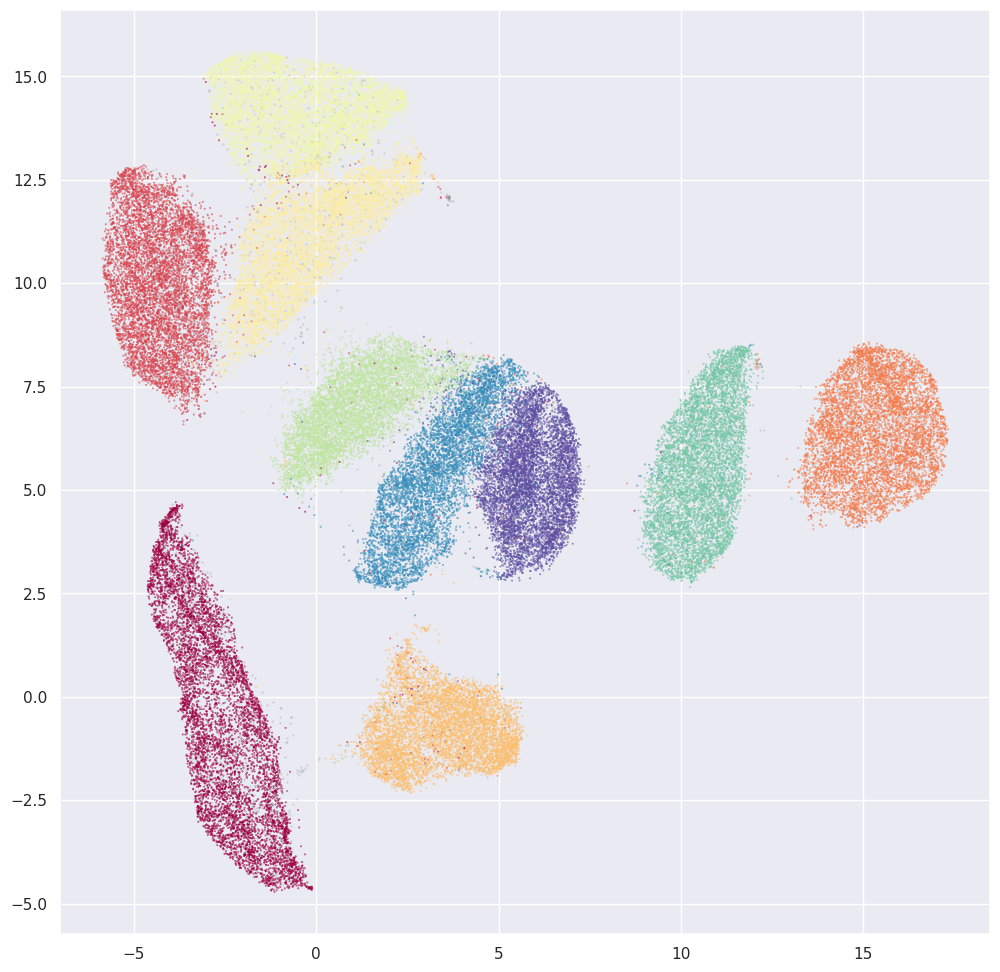

In [15]:
plt.scatter(*mnist_umap[mnist_clusters < 0].T, s=0.1, c="gray", alpha=0.5)
plt.scatter(*mnist_umap[mnist_clusters >= 0].T, s=0.1, c=mnist_clusters[mnist_clusters >=0], cmap="Spectral")

In [16]:
sklearn.metrics.adjusted_rand_score(mnist.target[mnist_clusters >= 0], mnist_clusters[mnist_clusters >= 0])

0.928096185810484

In [17]:
sklearn.metrics.adjusted_mutual_info_score(mnist.target[mnist_clusters >= 0], mnist_clusters[mnist_clusters >= 0])

0.9208606700366355

In [18]:
np.sum(mnist_clusters >= 0) / mnist_clusters.shape[0]

0.9544714285714285

As before; we run twice to ensure timings don't include JIT compile time.

In [19]:
%%time
uhdb_clusters = hdbscan.HDBSCAN(
    min_samples=5, min_cluster_size=300
).fit_predict(umap.UMAP(min_dist=1e-4).fit_transform(mnist.data))

CPU times: user 19min 2s, sys: 1min 33s, total: 20min 35s
Wall time: 34.4 s


In [20]:
%%time
uhdb_clusters = hdbscan.HDBSCAN(
    min_samples=5, min_cluster_size=300
).fit_predict(umap.UMAP(min_dist=1e-4).fit_transform(mnist.data))

CPU times: user 25min 48s, sys: 1min 16s, total: 27min 4s
Wall time: 39.4 s


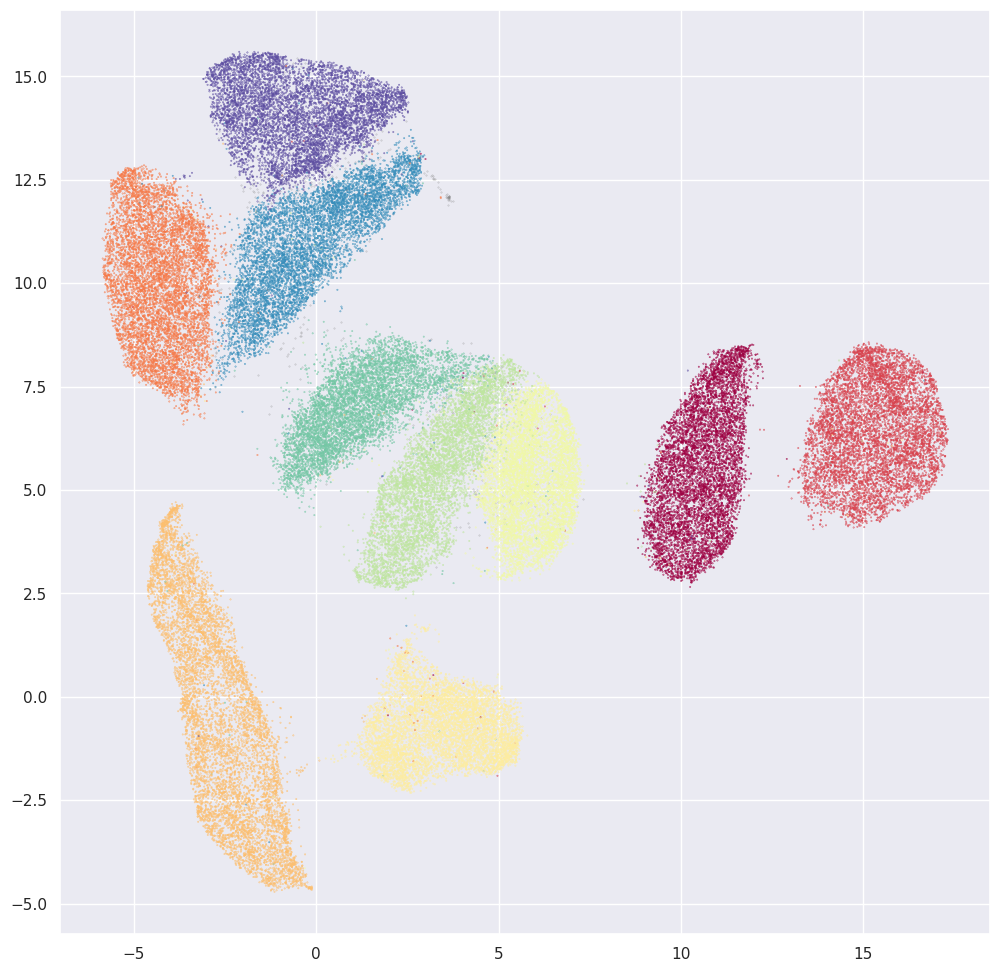

In [21]:
plt.scatter(*mnist_umap[uhdb_clusters < 0].T, s=0.1, c="gray", alpha=0.5)
plt.scatter(*mnist_umap[uhdb_clusters >= 0].T, s=0.1, c=uhdb_clusters[uhdb_clusters >=0], cmap="Spectral")

In [22]:
sklearn.metrics.adjusted_rand_score(mnist.target[uhdb_clusters >= 0], uhdb_clusters[uhdb_clusters >= 0])

0.9348912340721092

In [23]:
sklearn.metrics.adjusted_mutual_info_score(mnist.target[uhdb_clusters >= 0], uhdb_clusters[uhdb_clusters >= 0])

0.9215603201526636

In [24]:
np.sum(uhdb_clusters >= 0) / uhdb_clusters.shape[0]

0.9952285714285715

# New inputs I had from Leland

For a noisy 2-d dataset (that I called clusterable in previous notebooks) the algorithm above does not perform well. This is true even if we replace the normal distributions by the - proper for low dimensional - Gamma distributions. However, if instead of computing local nearest neighbor distributions we use a global one for this example, it works better. Moreover, if we use a log-normal distribution, instead of the proper Gamma, it again works better. However, the log-normal does not work as well on the high dimensional examples.
* Could a (global) prior distribution be used and updated locally? How?
* What makes the global distribution more adapted for the clusterable example: low dimensionality or high noise level in the data?
* What about log-normal distributions? Why is it that they better fit the observed distributions?

### Problem with min-cluster-size.

The min-cluster-size parameter is used to build the condensed tree that is in turn use to seed the label propagation step of the algorithm. Because of the label propagation step, the minimum cluster size given in the parameters can be much smaller than the minimum cluster size. With the Japanese character Kuzushiji-MNIST Dataset, we observe the following problem. If the min-cluster-size is not small enough, some of the smallish clusters are just labelled as noise. If we make the min-cluster-size small enough, we fix the problem but we introduce a new one: larger clusters get split into smaller ones. It's almost as if we would want to find persisting "propagated groups" over min-cluster-size values.

I have question here: can each point have a notion of at which min-cluster-size value it would have... no, does not work.